In [1]:
import cv2
import open3d as o3d
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
import pyrealsense2 as rs
from skimage.feature import canny
from skimage import data,morphology, segmentation
from skimage.color import rgb2gray, label2rgb
from skimage.filters import sobel
from skimage.exposure import histogram
import scipy.ndimage as nd
import copy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [7]:
file_path = "../../data/bag_files/16_11_2022/R6_G3_L_16_11_35d.bag" #R6_G4_R_7_9  R6_G4_L_21_9

FILTERING = True
LOAD_BAG = True
DECIMATION = 2
HOLE_FILLING = True

In [4]:
plt.rcParams.update({'font.size': 8})

def imshow(imgs, titles=None, rotate=True):
    plt.figure()
    #subplot(r,c) provide the no. of rows and columns
    n= len(imgs)
    if n == 2:
        x, y = 7, 15
    else:
        x,y = 17, 35
    rows = int(np.ceil(n/4))
    f, axarr = plt.subplots(rows,n, figsize=(x, y))
    for i in range(n): 
        if rotate:
            img = cv2.rotate(imgs[i], cv2.ROTATE_90_COUNTERCLOCKWISE)
        else:
            img = imgs[i]
        # use the created array to output your multiple images. In this case I have stacked 4 images vertically
        axarr[i].imshow(img)
        if not titles==None:
            axarr[i].set_title(titles[i])
            
def depth_filter( depth_image, min_d, max_d):     
    max_d = max_d / depth_scale
    min_d = min_d /depth_scale
    return np.where((depth_image > max_d) | (depth_image <= min_d), 0, depth_image)

def bg_remove_color(depth_image, color_image):
    grey_color = 0
    #depth image is 1 channel, color is 3 channels
    depth_image_3d = np.dstack((depth_image, depth_image, depth_image))
    return np.where(depth_image_3d, color_image, grey_color)

def green_color_mask(color, lower=[5,35,0], upper=[75,255,200]):
    #cv2.COLOR_RGB2BGR
    #r, g, b = cv2.split(color)
    
    #convert the BGR image to HSV colour space
    hsv = cv2.cvtColor(color, cv2.COLOR_RGB2HSV)

    #set the lower and upper bounds for the green hue
    lower_green = np.array(lower)  #[50,100,50]
    upper_green = np.array(upper)  #[70,255,255]

    #create a mask for green colour using inRange function
    mask = cv2.inRange(hsv, lower_green, upper_green)
    g_filtered = cv2.bitwise_and(color, color, mask=mask)
    mask = cv2.cvtColor(g_filtered, cv2.COLOR_RGB2GRAY)
    
    return mask

def depth_filter_by_mask(depth, mask):
    return np.where(mask, depth, 0)

    
def color_filter_by_mask(color, mask):
    mask_3d = np.dstack((mask, mask, mask))
    return np.where(mask_3d, color, 0)


def region_and_edge_based_segmentation_mask(image, negation=False, m1=10, m2=150):
    if type(image[0][0]) == np.uint16:
        img_wh = image
    else:
        img_wh = rgb2gray(color_image)

#     # apply edge segmentation
#     edges = canny(img_wh)

#     # fill regions to perform edge segmentation
#     fill_im = nd.binary_fill_holes(edges)
#     # imshow([edges,fill_im])
#     # plt.title('edges, Region Filling')

    # Region Segmentation
    elevation_map = sobel(img_wh)
#     plt.imshow(elevation_map)

    # Since, the contrast difference is not much. Anyways we will perform it
    markers = np.zeros_like(img_wh)
    m1 = m1/255
    m2 = m2/255
    markers[img_wh < m1] = 1 # 30/255
    markers[img_wh > m2] = 2 # 150/255

    # plt.imshow(markers)
    # plt.title('markers')

    # Perform watershed region segmentation
    segment1 = segmentation.watershed(elevation_map, markers)
    
    segment = nd.binary_fill_holes(segment1-1) #segment-1
    
    imshow([elevation_map, segment1], ["after sobel","segmentation watershed"])
    
    mask =  markers #segment markers
    
    if not negation:
        return np.where(mask, 1, 0)
    else:
        return np.where(mask, 0, 1)

def get_colorized_depth(depth):
    return cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=0.09), cv2.COLORMAP_JET)

<Figure size 640x480 with 0 Axes>

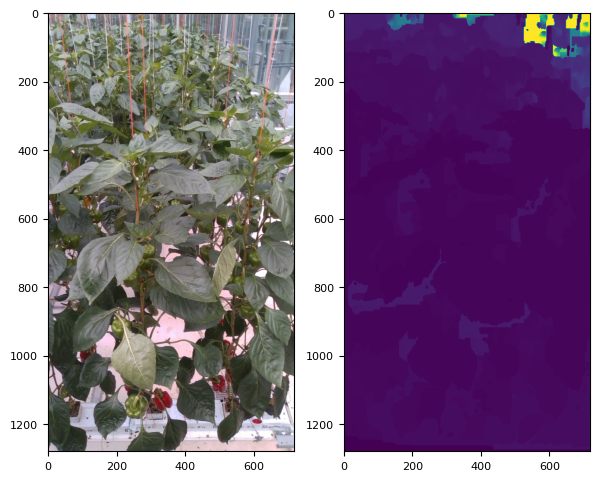

In [8]:
pipeline = rs.pipeline()
config = rs.config()
if LOAD_BAG:
    config.enable_device_from_file(file_path)

profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()

depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)
if DECIMATION:
    decimation = rs.decimation_filter()
    decimation.set_option(rs.option.filter_magnitude, DECIMATION)
spatial = rs.spatial_filter()
temporal = rs.temporal_filter()
hole_filling = rs.hole_filling_filter()


depth_scale = depth_sensor.get_depth_scale()

align_to = rs.stream.color
align = rs.align(align_to)
    
for i in range(20):
    frames = pipeline.wait_for_frames()
    
#-------------- filtering ----------------

if DECIMATION:
    frames = decimation.process(frames).as_frameset()
    
# Align the depth frame to color frame
aligned_frames = align.process(frames)

# Get aligned frames
aligned_depth_frame = aligned_frames.get_depth_frame().as_video_frame()
color_frame = aligned_frames.get_color_frame().as_video_frame()

# Added by Namal
if FILTERING:
    #aligned_depth_frame = decimation.process(aligned_depth_frame)
    aligned_depth_frame = depth_to_disparity.process(aligned_depth_frame)
    aligned_depth_frame = spatial.process(aligned_depth_frame)
    aligned_depth_frame = temporal.process(aligned_depth_frame)
    aligned_depth_frame = disparity_to_depth.process(aligned_depth_frame)
if HOLE_FILLING:   
    aligned_depth_frame = hole_filling.process(aligned_depth_frame)

# Validate that both frames are valid
if not aligned_depth_frame or not color_frame:
    print("Frame not found")

depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

imshow([color_image, depth_image],["",""])

<Figure size 640x480 with 0 Axes>

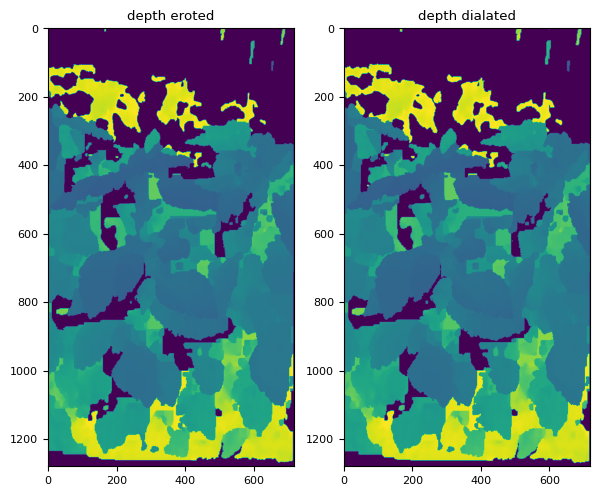

<Figure size 640x480 with 0 Axes>

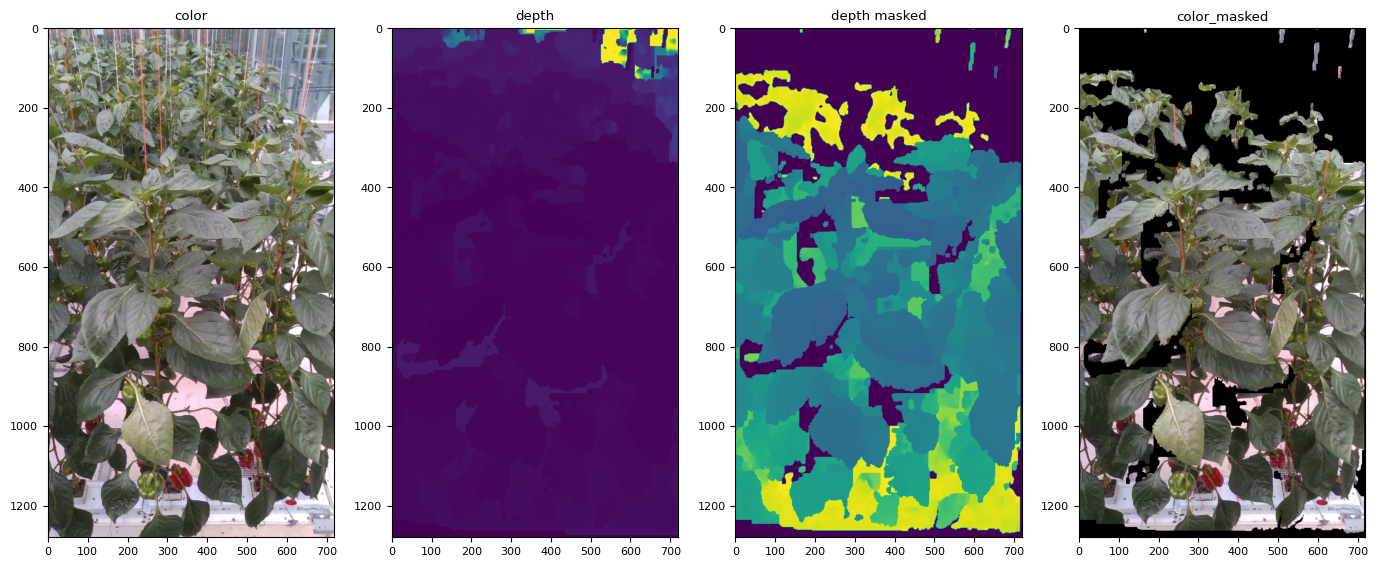

In [14]:
GREEN_MASK = False
ER_MASK_COLOR = False
ER_MASK_DEPTH = False
DEPTH_FILTERING = True

MASK = False

if DEPTH_FILTERING:
    # depth filtering
    depth_f = depth_filter(depth_image, 0.5, 2.3)
    
    KERNAL_SIZE = 3
    kernel = np.ones((KERNAL_SIZE, KERNAL_SIZE), np.uint8)  
    # Using cv2.erode() method 
    depth_fe = cv2.erode(depth_f, kernel, cv2.BORDER_REFLECT, iterations=1) #6
    depth_fed = cv2.dilate(depth_fe, kernel, iterations=1) #9
    imshow([ depth_fe, depth_fed], ["depth eroted", "depth dialated"])
    
# get green mask
if GREEN_MASK:
    #depth filtered color
    lower, upper = [0,0,0], [100,255,200] #[5,35,0], [75,255,200]  #[50,100,50] [70,255,255]
    color_d  = color_filter_by_mask(color_image, depth_fed)
    mask = green_color_mask(color_d, lower, upper)
    MASK = True
    
# get region and edge based mask
if ER_MASK_COLOR:
    #depth filtered color
    color_d  = color_filter_by_mask(color_image, depth_fed)
    mask = region_and_edge_based_segmentation_mask(color_d, True, m1=10, m2=150)
    MASK = True

if ER_MASK_DEPTH:
    mask = region_and_edge_based_segmentation_mask(depth_image)
    MASK = True

# mask = np.where(mask >0 and  mask2>0, 1, 0)
# print(mask[0][0])
    
if MASK:
    depth_m = depth_filter_by_mask(depth_fed, mask)
    color_m = color_filter_by_mask(color_image, mask)
else:
    depth_m = depth_fed
    color_m = color_filter_by_mask(color_image, depth_fed)
    
imshow([ color_image, depth_image, depth_m, color_m,], ['color','depth', "depth masked", "color_masked"])
    

In [15]:
intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, intrinsics.fx,
                                            intrinsics.fy, intrinsics.ppx,
                                            intrinsics.ppy)
flip_transform = [[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]
print(intrinsic)
pcd = o3d.geometry.PointCloud()
color = o3d.geometry.Image(color_m)
depth = o3d.geometry.Image(depth_m)

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color,
    depth,
    depth_scale=1000,
    depth_trunc=3,
    convert_rgb_to_intensity=False)

temp = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
temp.transform(flip_transform)
pcd.points = temp.points
pcd.colors = temp.colors
o3d.visualization.draw_geometries([pcd])

PinholeCameraIntrinsic with width = 1280 and height = 720.
Access intrinsics with intrinsic_matrix.


In [8]:
# mesh_r = copy.deepcopy(pcd).translate((0, 0, 0))
# R = mesh_r.get_rotation_matrix_from_xyz((0,  np.pi*(36.0)/180, 0)) #np.pi/2
# mesh_r.rotate(R, center=(0, 0, 0))
# mesh_r2 = copy.deepcopy(mesh_r).translate((2, 0, 0))
# R = mesh_r2.get_rotation_matrix_from_xyz((0, 0, np.pi/2))
# mesh_r2.rotate(R, center=(0, 0, 0))
# o3d.visualization.draw_geometries([mesh_r2])

In [43]:
file_path = "../../data/image_files/TEST_1280/scene_1280_0/integrated.ply"
file_path = "../../data/bag_files/R6_G4_L_21_9_D2_HF1/scene/integrated.ply"
#file_path = "../../data/bag_files/pruning/R6_G3_L_18_10_BP_D2_HF0/scene/integrated.ply"
# TEST_R6_G3_L_15fps_640_D2
print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud(file_path)
o3d.visualization.draw_geometries([pcd])

Load a ply point cloud, print it, and render it


In [16]:
pcd_vd = pcd.voxel_down_sample(voxel_size=0.005)
# o3d.visualization.draw_geometries([voxel_down_pcd])

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
    
cl, ind = pcd_vd.remove_radius_outlier(nb_points=40, radius=0.02)
display_inlier_outlier(pcd_vd, ind)
pcd1 = pcd_vd.select_by_index(ind)   

# pcd1.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# o3d.visualization.draw_geometries([pcd1], point_show_normal=True)

Showing outliers (red) and inliers (gray): 


In [17]:
# VS, MIN_POINTS, EPS =0.02, 80, 0.08  #stichted cloud
VS, MIN_POINTS, EPS =0.01, 80, 0.05 #rgbd pcd

pcd_vd1 = pcd.voxel_down_sample(voxel_size=VS)

cl, ind = pcd_vd1.remove_radius_outlier(nb_points=40, radius=0.08)
display_inlier_outlier(pcd_vd1, ind)
pcd_vd1 = pcd_vd1.select_by_index(ind) 

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd_vd1.cluster_dbscan(eps=EPS, min_points=MIN_POINTS, print_progress=True)) # 0.05 ,80
    
mask = np.where((labels > -1), 1, 0)
# mask = np.where((labels < 0) | (labels >= labels.max()-5), 0, 1)
m=list(np.nonzero(mask)[0])
pcd_vd2 = pcd_vd1.select_by_index(m)
    
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd_vd1.colors = o3d.utility.Vector3dVector(colors[:, :3])
pcd_vd1.translate((2, 0, 0))
o3d.visualization.draw_geometries([pcd_vd1, pcd_vd2])

Showing outliers (red) and inliers (gray): 
[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 50
point cloud has 50 clusters
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [18]:
# Manual Plane adding
def degree(x):
    return np.pi*(x)/180

mesh_r = copy.deepcopy(pcd_vd2).translate((0, 0, 0))
R = mesh_r.get_rotation_matrix_from_xzy((degree(0), degree(90), degree(35))) #-36,84,0: x,z,y
mesh_r.rotate(R, center=(0, 0, 0))


plane1 = o3d.geometry.TriangleMesh.create_box(width=2.0, height=0.001, depth=2.0)
plane1.translate((-1.0, -2.25, -2.0)) # x,z,y

plane2 = o3d.geometry.TriangleMesh.create_box(width=2.0, height=0.001, depth=2.0)
plane2.translate((-1.0, -0.25, -2.0)) # x,z,y

plane3 = o3d.geometry.TriangleMesh.create_box(width=2.0, height=2.0, depth=0.001)
plane3.translate((-1.0, -2.1, -1.8)) # x,z,y

aabb = mesh_r.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = mesh_r.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([mesh_r, aabb, plane1, plane2, plane3])

In [22]:
#eliminate background plants
dc1, hc1, lc = -2.0, -2.25, 0.25

d=np.asarray(mesh_r.points).T[2]
l=np.asarray(mesh_r.points).T[0]
h=np.asarray(mesh_r.points).T[1]
ind_d = np.where((d > dc1), 1, 0)
ind_l = np.where(( (l > l.max()-lc) | (l < l.min()+lc)), 0, 1)
ind_h = np.where((h > hc1), 1, 0)

ind =  ind_d & ind_h  & ind_l 

ind_d=list(np.nonzero(ind)[0])

mesh_r2 = mesh_r.select_by_index(ind_d)


aabb = mesh_r2.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = mesh_r2.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([mesh_r2, aabb])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [21]:
#Pointcloud based bounding box
aabb = mesh_r.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = mesh_r.get_oriented_bounding_box()
obb.color = (0, 1, 0)

o3d.visualization.draw_geometries([mesh_r, aabb, plane1, plane2])


[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [20]:
max_p=mesh_r2.get_max_bound()
min_p=mesh_r2.get_min_bound()
print(max_p)
print(min_p)
z = max_p[2]-min_p[2]
x = max_p[0]-min_p[0]
y = max_p[1]-min_p[1]
print(x, y, z)

print("Height: {}".format(max_p[1]-(-2.25)))
print("Height2: {}".format((-2.25-min_p[1])))

np.asarray(aabb.get_box_points())

[ 0.60580454 -0.19206417 -0.44976722]
[-0.63361199 -2.24966732 -1.50425362]
1.2394165342669021 2.0576031424269097 1.0544863972614023
Height: 2.057935826822402
Height2: -0.0003326843954924996


array([[-0.63361199, -2.24966732, -1.50425362],
       [ 0.60580454, -2.24966732, -1.50425362],
       [-0.63361199, -0.19206417, -1.50425362],
       [-0.63361199, -2.24966732, -0.44976722],
       [ 0.60580454, -0.19206417, -0.44976722],
       [-0.63361199, -0.19206417, -0.44976722],
       [ 0.60580454, -2.24966732, -0.44976722],
       [ 0.60580454, -0.19206417, -1.50425362]])

In [46]:
x = mesh_r2.hidden_point_removal()
o3d.visualization.draw_geometries([x])
# plt.imshow(np.asarray(x))

TypeError: hidden_point_removal(): incompatible function arguments. The following argument types are supported:
    1. (self: open3d.cpu.pybind.geometry.PointCloud, camera_location: numpy.ndarray[numpy.float64[3, 1]], radius: float) -> Tuple[open3d::geometry::TriangleMesh, List[int]]

Invoked with: PointCloud with 22163 points.

In [64]:
plane_model, inliers = mesh_r.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Plane equation: -0.23x + 0.01y + 0.97z + 0.74 = 0


In [34]:
mesh = o3d.geometry.TriangleMesh.create_coordinate_frame()
mesh_r = copy.deepcopy(mesh).translate((2, 0, 0))
R = mesh.get_rotation_matrix_from_xyz((degree(0), degree(0),degree(90)))
mesh_r.rotate(R, center=(0, 0, 0))
o3d.visualization.draw_geometries([mesh, mesh_r])

### 